In [1]:
import notebook_import
import arrhythmia.experimental.mitdb as mitdb
import arrhythmia.model.helpers as helpers
import numpy as np

In [2]:
# Load all mitdb records

full_data = mitdb.get_records(mitdb.full_ds)

In [3]:
# Slice all data into time frames of size 10 min + 5 min

pred_window = 360 * 10
post_window = 360 * 5

def slice_record(record, pred_len=pred_window, post_len=post_window, increment=360, check_pred=True):
    for start in range(0, len(record[0]) - pred_len - post_len, increment):
        pred_end = start + pred_len
        post_end = pred_end + post_len
        
        pred = record[0][start:pred_end]
        post = record[0][pred_end:post_end]
        
        pred_inds = np.logical_and(start <= record[1], record[1] < pred_end)
        post_inds = np.logical_and(pred_end <= record[1], record[1] < post_end)
        if check_pred:
            pred_labels = record[2][pred_inds]
            if np.all(pred_labels == 'N'):
                pred_result = pred, record[1][pred_inds], pred_labels
                post_result = post, record[1][post_inds], record[2][post_inds]
                yield pred_result, post_result
        else:
            pred_result = pred, record[1][pred_inds], record[2][pred_inds]
            post_result = post, record[1][post_inds], record[2][post_inds]
            yield pred_result, post_result

data = [list(slice_record(record, check_pred=False)) for record in full_data]
len(data)

44

In [4]:
# Convert loaded data into model input and expected classes

def to_classes(labels):
    return 1.0 if np.sum(labels != 'N') > 3 else 0.0

input_data = [pred[0] for rec in data for pred, post in rec]
classes = [to_classes(post[2]) for rec in data for pred, post in rec]
input_data = np.array(input_data)
classes = np.array(classes)
unique, cnts = np.unique(classes, return_counts=True)
print(unique, cnts)

[0. 1.] [73871  4933]


In [5]:
def normalize_mean_std(values):
    mean = np.mean(values, axis=1)
    std = np.std(values, axis=1)
    return ((values.T - mean) / std).T

input_data_n = normalize_mean_std(input_data)

In [9]:
# Define some helpers
# NOTE: Good candidates to separate into source file

from keras.models import Model
from keras.layers import Input, Dense
import keras.backend as K
from sklearn.model_selection import StratifiedKFold
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

def sensitivity(y_true, y_pred):
    dot = K.sum(y_true * y_pred)
    summ = K.sum(y_true)
    return K.switch(K.equal(summ, 0.0), 1.0, dot / summ)

def specificity(y_true, y_pred):
    rev_y_true = y_true * (-1.0) + 1.0
    rev_y_pred = y_pred * (-1.0) + 1.0
    return sensitivity(rev_y_true, rev_y_pred)

def younden(y_true, y_pred):
    return sensitivity(y_true, y_pred) + specificity(y_true, y_pred) - 1.0

metrics = ['accuracy', sensitivity, specificity, younden]
callbacks = [EarlyStopping(monitor='val_loss', patience=4)]

def print_metrics(names, values):
    pairs = zip(names, values)
    strings = ['{}: {:.2f}%'.format(name, val * 100) for name, val in pairs]
    print(', '.join(strings))
    
def print_final(names, values):
    mean = np.mean(values, axis=0)
    std = np.std(values, axis=0)
    triples = zip(names, mean, std)
    strings = ['{}: {:.2f}% (+/-{:.2f}%)'.format(name, mean * 100, std * 100) for name, mean, std in triples]
    print(', '.join(strings))

def plot_history(history):
    w_val_acc = 'val_acc' in history.history
    w_val_loss = 'val_loss' in history.history
    # plot history for accuracy
    plt.plot(history.history['acc'])
    if w_val_acc:
        plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    # plot history for loss
    plt.plot(history.history['loss'])
    if w_val_loss:
        plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
kfold_seed = 7
kfold_splits = 5

def test_model(model_builder):
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=kfold_seed)
    cvscores = []
    last_model = None
    last_history = None
    best_acc = None
    for train, test in kfold.split(input_data_n, classes):
        # Build model
        model = model_builder()
        # Fit the model
        history = model.fit(input_data_n[train],
                            classes[train],
                            epochs=100,
                            callbacks=callbacks,
                            validation_data=(input_data_n[test], classes[test]),
                            batch_size=100,
                            verbose=0)
        print("Trained for {} epochs".format(len(history.epoch)))
        # Evaluate the model
        scores = model.evaluate(input_data_n[test], classes[test], verbose=0)
        print_metrics(model.metrics_names, scores)
        cvscores.append(scores)
        if not best_acc or scores[1] < best_acc:
            best_acc = scores[1]
            last_model = model
            last_history = history
        
    print_final(model.metrics_names, cvscores)
    plot_history(last_history)
    return last_model

In [10]:
# Let's evaluate simplest model
def simple_model():
    inputs = Input(shape=(pred_window,))
    x = Dense(10, activation='relu')(inputs)
    x = Dense(5, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=metrics)
    return model

Trained for 13 epochs
loss: 21.97%, acc: 93.76%, sensitivity: 76.81%, specificity: 94.36%, younden: 71.17%
Trained for 12 epochs
loss: 21.89%, acc: 93.67%, sensitivity: 75.98%, specificity: 94.22%, younden: 70.20%
Trained for 14 epochs
loss: 22.12%, acc: 93.60%, sensitivity: 78.17%, specificity: 94.15%, younden: 72.32%
Trained for 15 epochs
loss: 22.86%, acc: 93.74%, sensitivity: 77.52%, specificity: 94.31%, younden: 71.83%
Trained for 19 epochs
loss: 20.65%, acc: 93.80%, sensitivity: 77.55%, specificity: 93.67%, younden: 71.22%
loss: 21.90% (+/-0.71%), acc: 93.71% (+/-0.07%), sensitivity: 77.21% (+/-0.75%), specificity: 94.14% (+/-0.25%), younden: 71.35% (+/-0.71%)


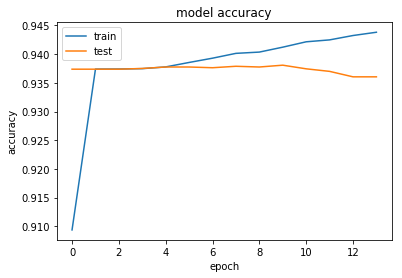

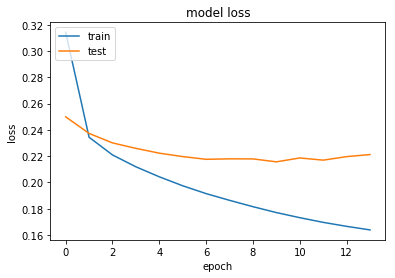

In [11]:
s_model = test_model(simple_model)
s_model.save('bip_simple_model.hdf5')

In [12]:
from keras.layers import Conv1D, MaxPooling1D, Reshape, Flatten

def conv_model():
    inputs = Input(shape=(pred_window,))
    x = Reshape((pred_window, 1))(inputs)
    x = Conv1D(10, 64, activation='relu')(x)
    x = MaxPooling1D(pool_size=4)(x)
    x = Conv1D(1, 16, activation='relu')(x)
    x = MaxPooling1D(pool_size=4)(x)
    x = Flatten()(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=metrics)
    return model

Trained for 37 epochs
loss: 14.71%, acc: 94.33%, sensitivity: 77.87%, specificity: 97.17%, younden: 75.04%
Trained for 24 epochs
loss: 15.05%, acc: 94.04%, sensitivity: 76.59%, specificity: 96.84%, younden: 73.44%
Trained for 28 epochs
loss: 15.01%, acc: 94.04%, sensitivity: 78.17%, specificity: 97.21%, younden: 75.39%
Trained for 21 epochs
loss: 14.81%, acc: 94.01%, sensitivity: 78.77%, specificity: 95.73%, younden: 74.50%
Trained for 26 epochs
loss: 14.26%, acc: 94.43%, sensitivity: 78.21%, specificity: 96.04%, younden: 74.25%
loss: 14.77% (+/-0.28%), acc: 94.17% (+/-0.18%), sensitivity: 77.92% (+/-0.73%), specificity: 96.60% (+/-0.61%), younden: 74.52% (+/-0.67%)


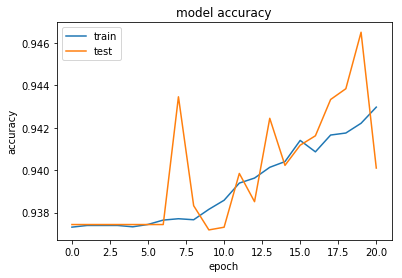

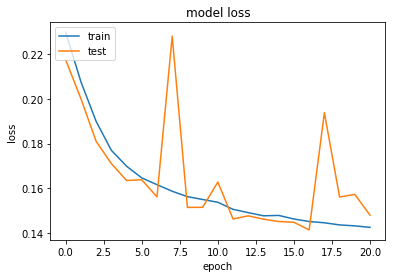

In [13]:
# TODO Train this model
c_model = test_model(conv_model)
c_model.save('bip_conv_model.hdf5')

In [ ]:
# TODO Checkpoints - support training and testing in multiple sessions
# TODO History - return best model not 4 epochs after it
# TODO Fix seed for weights intialization - make results reproducible